In [1]:
from libtiff import TIFF
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patheffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import shapefile
import pandas as pd
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
#from cartopy.io.shapereader import Reader
#from cartopy.feature import ShapelyFeature
from wrf import getvar, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords, to_np
from netCDF4 import Dataset
import wrf

import rasterio
from rasterio.mask import mask
import fiona

from datetime import datetime
import cartopy.feature as cfeature


In [2]:
def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return int(np.floor( ( lon + 180 ) / 6) + 1)

def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    lonlat_start = (ccrs.PlateCarree().transform_point(bar_xs[0],sbcy,utm))
    lonlat_end = (ccrs.PlateCarree().transform_point(bar_xs[1],sbcy,utm))
    return(lonlat_start,lonlat_end)

In [3]:
dem = rasterio.open('DEM.tif')
dem_crs = dem.crs
this_transform = dem.transform
left,bottom,right,top = dem.bounds
dem_dat = dem.read()[0]
dem_sampled = dem_dat[::4,::4]

In [4]:
OBS_LAT = 37.354621121280424
OBS_LON = -108.43818826792396

ncfile = Dataset('no_eclipse/geo_em.d01.nc','r')
hgt_d01 = getvar(ncfile,'HGT_M')
lats_d01,lons_d01 = latlon_coords(hgt_d01)
cart_proj = get_cartopy(hgt_d01)
xlim_d01 = wrf.cartopy_xlim(hgt_d01)
ylim_d01 = wrf.cartopy_ylim(hgt_d01)

ncfile = Dataset('no_eclipse/geo_em.d02.nc','r')
hgt_d02 = getvar(ncfile,'HGT_M')
lats_d02,lons_d02 = latlon_coords(hgt_d02)
xlim_d02 = wrf.cartopy_xlim(hgt_d02)
ylim_d02 = wrf.cartopy_ylim(hgt_d02)

ncfile = Dataset('no_eclipse/geo_em.d03.nc','r')
hgt_d03 = getvar(ncfile,'HGT_M')
lats_d03,lons_d03 = latlon_coords(hgt_d03)
xlim_d03 = wrf.cartopy_xlim(hgt_d03)
ylim_d03 = wrf.cartopy_ylim(hgt_d03)

/research/modules/mpich/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:799: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/research/modules/mpich/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/research/modules/mpich/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle 

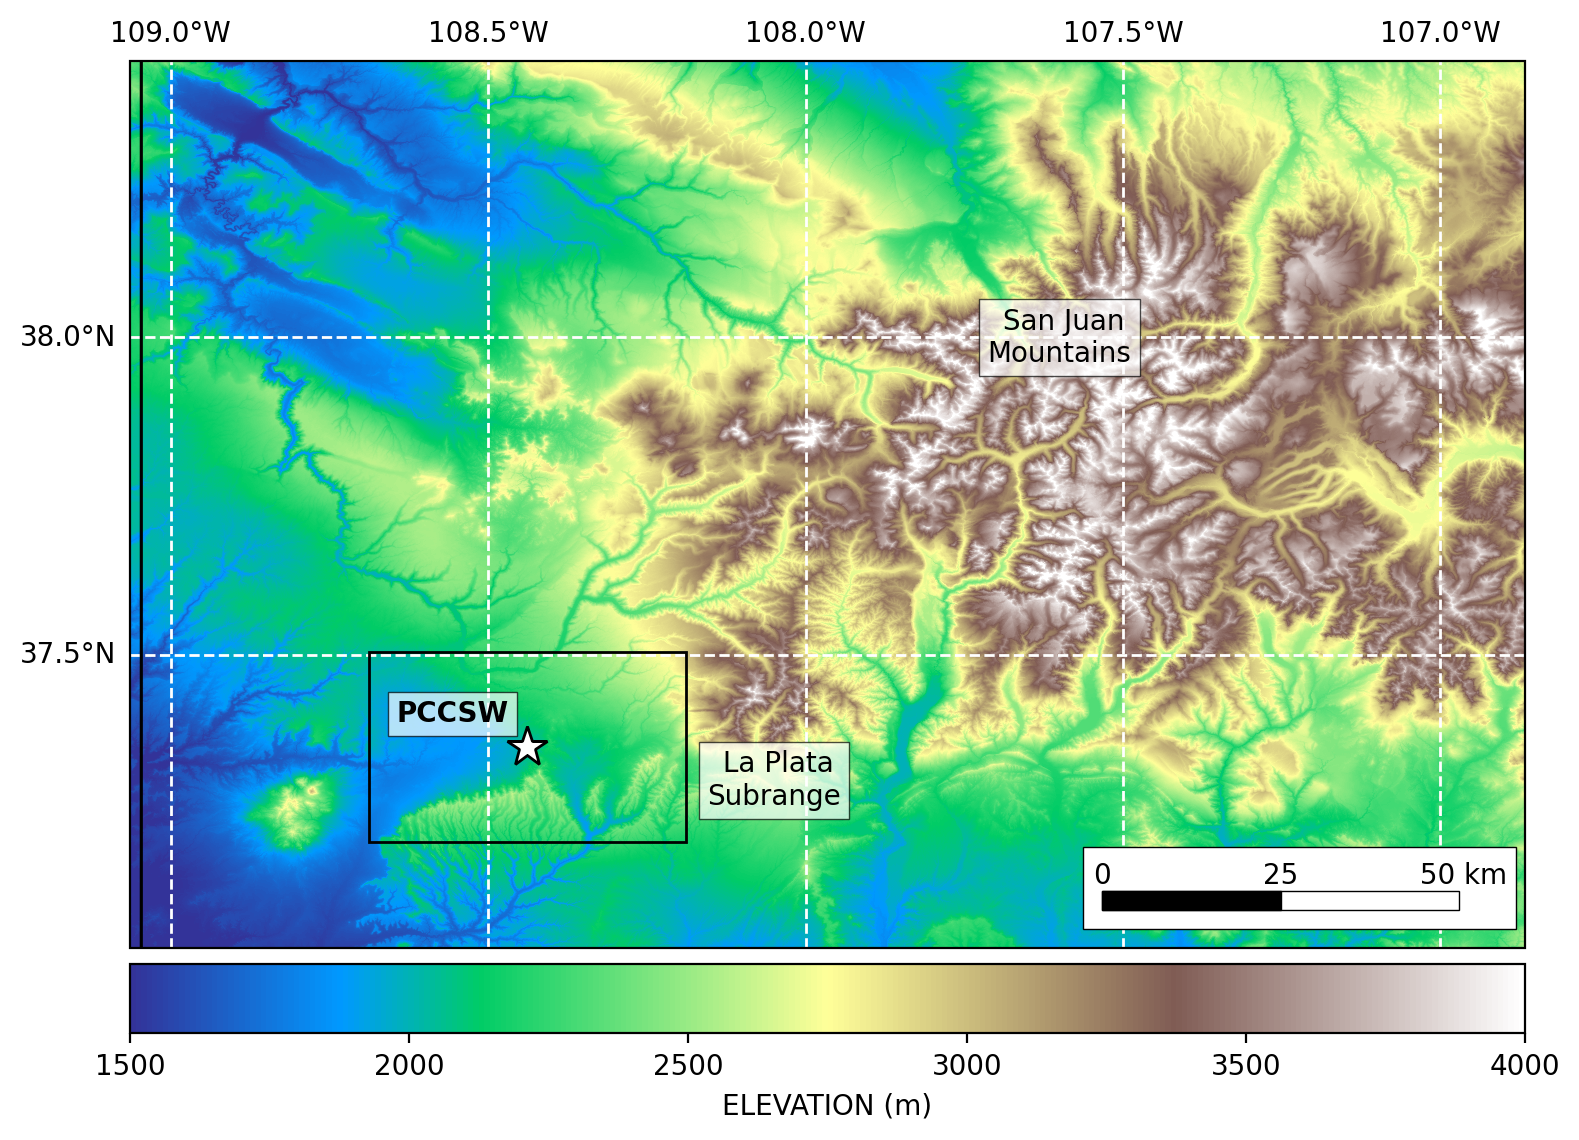

In [5]:
fig = plt.figure(figsize=(8,8),dpi=200,facecolor='w')
ax = plt.axes(projection=ccrs.PlateCarree())
cmap = plt.cm.terrain
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom cmap',cmaplist,cmap.N)
bounds = np.linspace(1000,4000,14)
norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
#im = plt.imshow(dem_sampled,cmap=cmap,norm=norm,origin='upper',
#                interpolation='nearest',extent=(left,right,bottom,top))
im = plt.imshow(dem_dat,cmap=plt.cm.terrain,vmin=1500,vmax=4000,origin='upper',
                interpolation='nearest',extent=(left,right,bottom,top))
cb = plt.colorbar(im,orientation='horizontal',ticks=np.linspace(1000,4000,7),pad=0.01)
cb.set_label('ELEVATION (m)')
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

x_min,y_min = ccrs.PlateCarree().transform_point(xlim_d03[0],ylim_d03[0],cart_proj)
x_max,y_max = ccrs.PlateCarree().transform_point(xlim_d03[1],ylim_d03[1],cart_proj)
ax.set_extent([x_min,x_max,y_min,y_max])

ax.add_patch(mpl.patches.Rectangle(xy=[OBS_LON-0.25, OBS_LAT-0.15], width=0.5, height=0.3,
                                facecolor='none', edgecolor='k',
                                transform=ccrs.PlateCarree()))

#Add Scale Bar
thickness = 0.03 #degrees
length = 25 #km
start,end = scale_bar(ax,ccrs.PlateCarree(), length, location=(0.75, 0.05))
#add outer box
outr = plt.Rectangle((start[0]-0.03,start[1]-0.03), (end[0]-start[0])*2+thickness*4, thickness+0.1, 
                     facecolor='w', edgecolor='k', linewidth=0.5,zorder=1)
ax.add_artist(outr)
long = plt.Rectangle((start), (end[0]-start[0])*2, thickness,
                     facecolor='w', edgecolor='k', linewidth=0.5,zorder=2)
ax.add_artist(long)
short = plt.Rectangle((start), (end[0]-start[0])*1, thickness,
                     facecolor='k', edgecolor='k', linewidth=0.5,zorder=3)
ax.add_artist(short)
ax.text(start[0], start[1]+thickness*1.1, f'{0}',
        size=10, color='k', horizontalalignment='center', verticalalignment='bottom', zorder=4)
ax.text(end[0]+(end[0]-start[0])*0.0, start[1]+thickness*1.1, f'{length}',
        size=10, color='k', horizontalalignment='center', verticalalignment='bottom', zorder=4)
ax.text(end[0]+(end[0]-start[0]), start[1]+thickness*1.1, f' {length*2} km',
        size=10, color='k', horizontalalignment='center', verticalalignment='bottom', zorder=4)

#add lat lon lines
stepx=0.5
stepy=0.5
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  xlocs=np.arange(-180,360,stepx),
                  ylocs=np.arange(-90,180,stepy),
                  linewidth=1, color='w', alpha=1.0, linestyle='--',zorder=0)
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xformatter = LongitudeFormatter(number_format='.1f')
gl.yformatter = LatitudeFormatter(number_format='.1f')

plt.plot(OBS_LON,OBS_LAT,'*',markersize=15,markeredgecolor='k',markerfacecolor='w',zorder=10)
ax.text(OBS_LON-0.03,OBS_LAT+0.03,'PCCSW',ha='right',va='bottom',bbox=dict(boxstyle='square',fc='white',ec='k',lw=0.5,alpha=0.7),weight='bold')

ax.text(-108.05,37.35,' La Plata\nSubrange',ha='center',va='top',bbox=dict(boxstyle='square',fc='white',ec='k',lw=0.5,alpha=0.7))
ax.text(-107.6,38.0,' San Juan\nMountains',ha='center',va='center',bbox=dict(boxstyle='square',fc='white',ec='k',lw=0.5,alpha=0.7))


plt.tight_layout()
plt.savefig('d03_elevation.png')

/research/modules/mpich/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:799: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/research/modules/mpich/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/research/modules/mpich/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle 

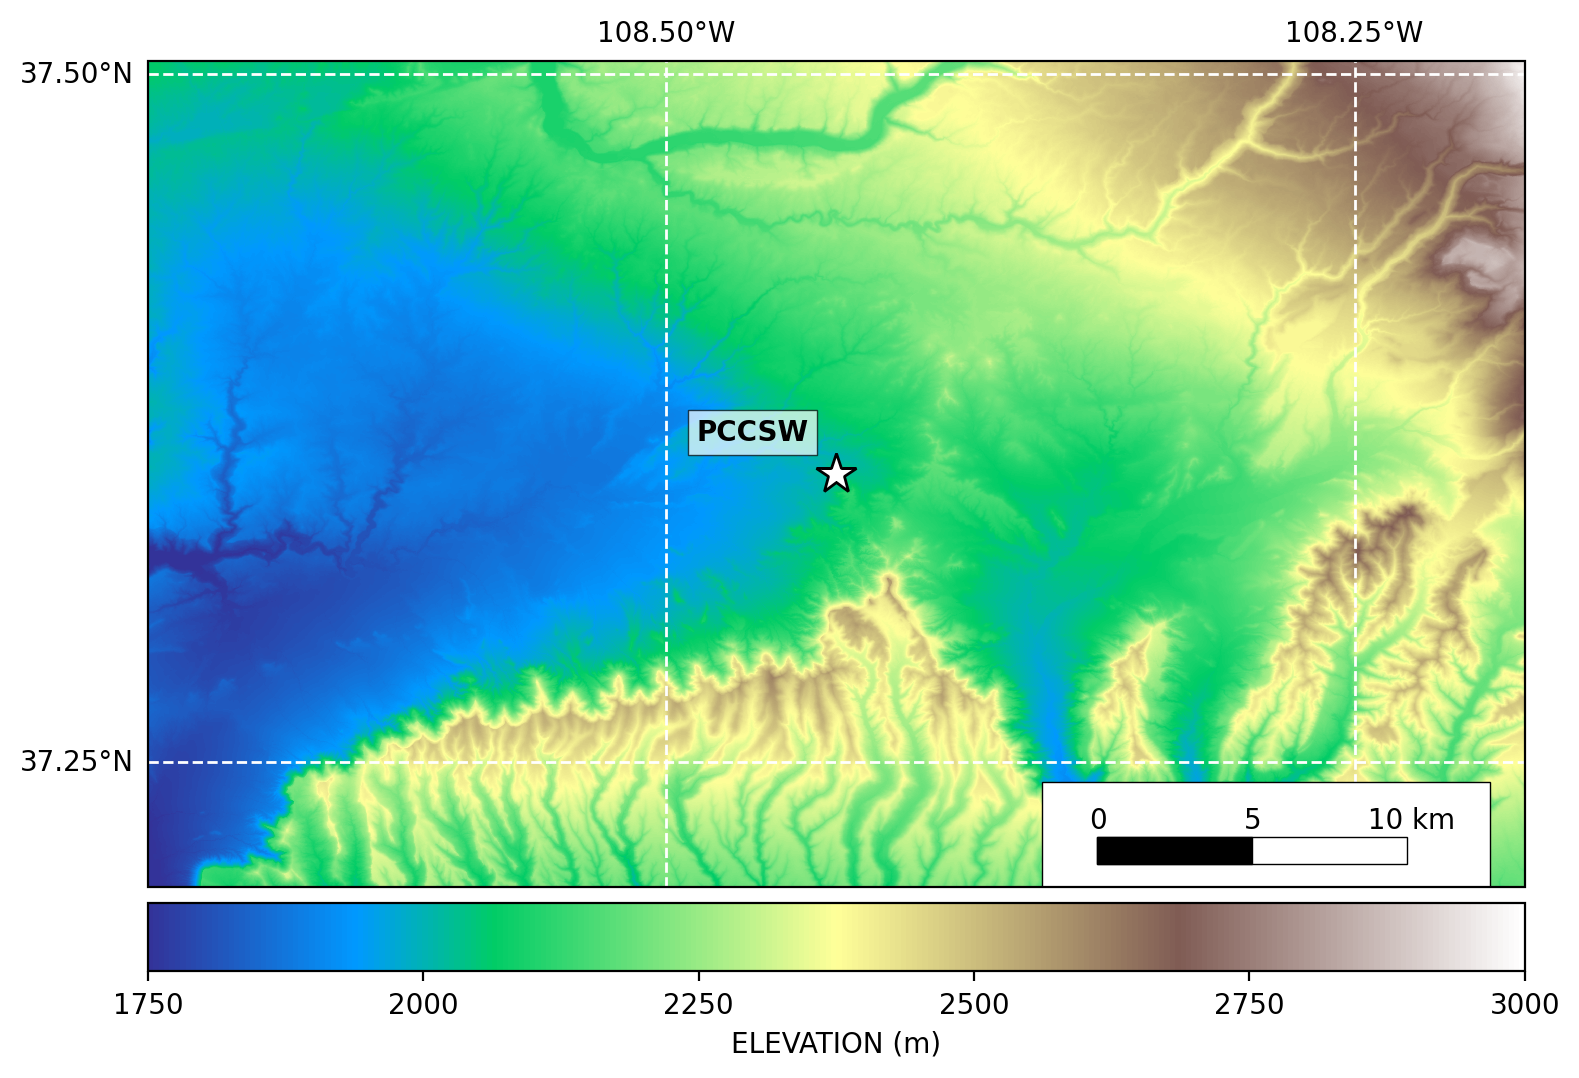

In [6]:
fig = plt.figure(figsize=(8,8),dpi=200,facecolor='w')
ax = plt.axes(projection=ccrs.PlateCarree())
cmap = plt.cm.terrain
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom cmap',cmaplist,cmap.N)
bounds = np.linspace(1000,4000,14)
norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
#im = plt.imshow(dem_sampled,cmap=cmap,norm=norm,origin='upper',
#                interpolation='nearest',extent=(left,right,bottom,top))
im = plt.imshow(dem_dat,cmap=plt.cm.terrain,vmin=1750,vmax=3000,origin='upper',
                interpolation='nearest',extent=(left,right,bottom,top))
cb = plt.colorbar(im,orientation='horizontal',ticks=np.linspace(1000,4000,13),pad=0.01)
cb.set_label('ELEVATION (m)')
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

x_min,y_min = ccrs.PlateCarree().transform_point(xlim_d03[0],ylim_d03[0],cart_proj)
x_max,y_max = ccrs.PlateCarree().transform_point(xlim_d03[1],ylim_d03[1],cart_proj)
ax.set_extent([OBS_LON-0.25,OBS_LON+0.25,OBS_LAT-0.15,OBS_LAT+0.15])

#Add Scale Bar
thickness = 0.01 #degrees
length = 5 #km
start,end = scale_bar(ax,ccrs.PlateCarree(), length, location=(0.75, 0.05))
#add outer box
outr = plt.Rectangle((start[0]-0.02,start[1]-0.01), (end[0]-start[0])*2+thickness*5, thickness+0.03, 
                     facecolor='w', edgecolor='k', linewidth=0.5,zorder=1)
ax.add_artist(outr)
long = plt.Rectangle((start), (end[0]-start[0])*2, thickness,
                     facecolor='w', edgecolor='k', linewidth=0.5,zorder=2)
ax.add_artist(long)
short = plt.Rectangle((start), (end[0]-start[0])*1, thickness,
                     facecolor='k', edgecolor='k', linewidth=0.5,zorder=3)
ax.add_artist(short)
ax.text(start[0], start[1]+thickness*1.1, f'{0}',
        size=10, color='k', horizontalalignment='center', verticalalignment='bottom', zorder=4)
ax.text(end[0]+(end[0]-start[0])*0.0, start[1]+thickness*1.1, f'{length}',
        size=10, color='k', horizontalalignment='center', verticalalignment='bottom', zorder=4)
ax.text(end[0]+(end[0]-start[0]), start[1]+thickness*1.1, f' {length*2} km',
        size=10, color='k', horizontalalignment='center', verticalalignment='bottom', zorder=4)

#add lat lon lines
stepx=0.25
stepy=0.25
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  xlocs=np.arange(-180,360,stepx),
                  ylocs=np.arange(-90,180,stepy),
                  linewidth=1, color='w', alpha=1.0, linestyle='--',zorder=0)
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xformatter = LongitudeFormatter(number_format='.2f')
gl.yformatter = LatitudeFormatter(number_format='.2f')

plt.plot(OBS_LON,OBS_LAT,'*',markersize=15,markeredgecolor='k',markerfacecolor='w',zorder=10)
ax.text(OBS_LON-0.01,OBS_LAT+0.01,'PCCSW',ha='right',va='bottom',bbox=dict(boxstyle='square',fc='white',ec='k',lw=0.5,alpha=0.7),weight='bold')


plt.tight_layout()
plt.savefig('zoomed_elevation.png')